In [1]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
from bw_temporalis import easy_timedelta_distribution, TemporalisLCA

In [2]:
bd.projects.set_current('tictac2')

In [3]:
bd.databases

Databases dictionary with 1 object(s):
	wind-example

In [4]:
# del bd.databases['wind-example']

In [5]:
bd.databases

Databases dictionary with 1 object(s):
	wind-example

In [22]:
generated_electricity_over_lifetime = 4.38e9 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.80
LT = 25 # 25 years lifetime of a wind turbine

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-4,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=5,
                    kind = 'triangular',
                    param = -1
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'normal',
                    param = 0.1
                )
            },
            # aggregate the rest to direct co2 emissions
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 200000,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 88301.14it/s]

Vacuuming database 


# Result for 1 WT

In [25]:
bd.databases

Databases dictionary with 1 object(s):
	wind-example

In [26]:
bd.Method(("GWP", "wind-example")).write([
    (('wind-example', "CO2"), 1),
])

In [27]:
lca = bc.LCA({('wind-example', 'electricity-production-wind'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

0.00026348474919501795

In [28]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 7


In [29]:
tl = tlca.build_timeline()

In [30]:
import seaborn as sb
import pandas as pd

In [31]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [32]:
# df

In [33]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

In [34]:
# df2

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by 1WT')

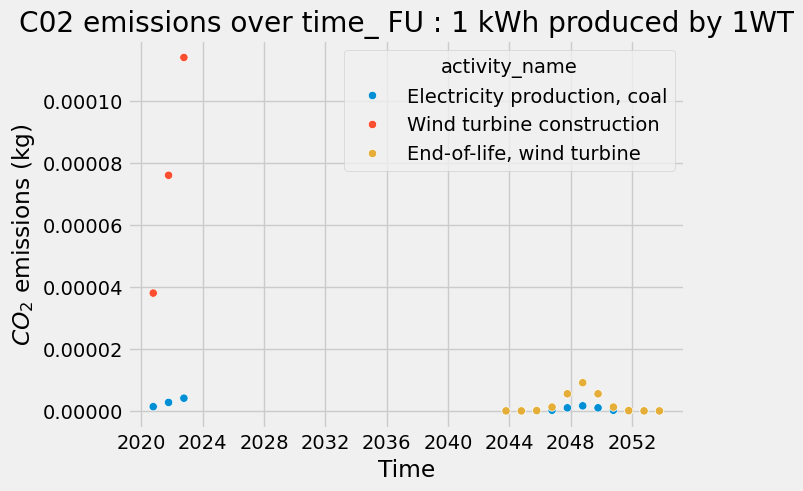

In [35]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by 1WT") #right after being put in service

# Results for elec mix

In [36]:
lca = bc.LCA({('wind-example', 'electricity-mix'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

0.1802107857163343

In [37]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 4


In [38]:
tl = tlca.build_timeline()

In [39]:
import seaborn as sb
import pandas as pd

In [40]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [45]:
df

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit
0,2020-10-10 20:16:29,0.000030,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
1,2021-10-11 02:05:41,0.000061,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
2,2022-10-11 07:54:53,0.000091,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
3,2023-10-11 13:44:05,0.180000,1,4,"Electricity production, coal",kilowatt hour,carbon dioxide,kilogram


In [42]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

In [43]:
# df2

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by electricity mix')

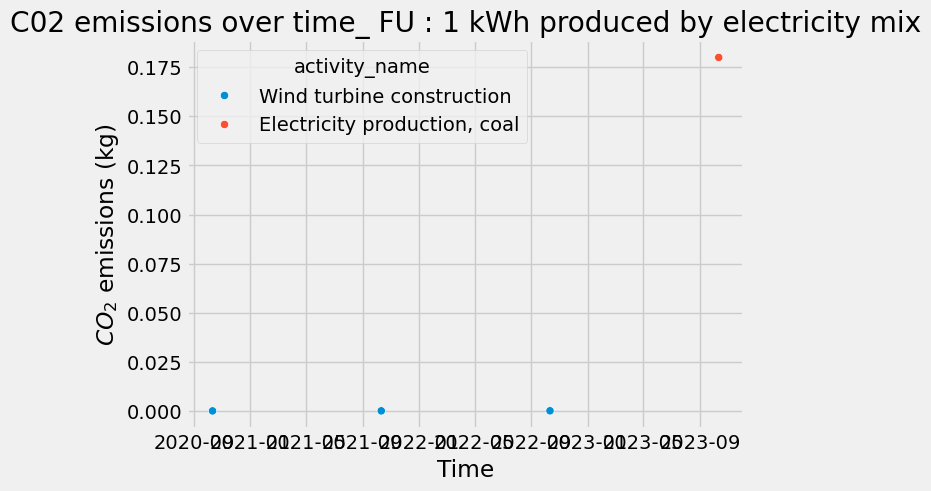

In [44]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

Let's reduce the fraction of coal prod in the mix

In [46]:
del bd.databases['wind-example']

In [47]:
bd.databases

Databases dictionary with 0 objects

In [48]:
generated_electricity_over_lifetime = 4.38e9 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.95
LT = 25 # 25 years lifetime of a wind turbine

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-4,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=5,
                    kind = 'triangular',
                    param = -1
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'normal',
                    param = 0.1
                )
            },
            # aggregate the rest to direct co2 emissions
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 200000,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 65922.26it/s]

Vacuuming database 


In [49]:
lca = bc.LCA({('wind-example', 'electricity-mix'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

0.04524152774118663

In [50]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 5


In [51]:
tl = tlca.build_timeline()

In [52]:
import seaborn as sb
import pandas as pd

In [53]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [54]:
df

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit
0,2020-10-10 20:23:46,3.614916e-05,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
1,2021-10-11 02:12:58,7.229832e-05,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
2,2022-10-11 08:02:10,1.084475e-04,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
3,2023-10-11 13:51:22,4.500000e-02,1,4,"Electricity production, coal",kilowatt hour,carbon dioxide,kilogram
4,2043-10-11 10:15:22,3.224620e-11,1,8,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
5,2044-10-10 16:04:34,2.902710e-09,1,8,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
6,2045-10-10 21:53:46,9.612456e-08,1,8,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
7,2046-10-11 03:42:58,1.171037e-06,1,8,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
8,2047-10-11 09:32:10,5.248223e-06,1,8,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
9,2048-10-10 15:21:22,8.652857e-06,1,8,"End-of-life, wind turbine",unit,carbon dioxide,kilogram


In [55]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by electricity mix')

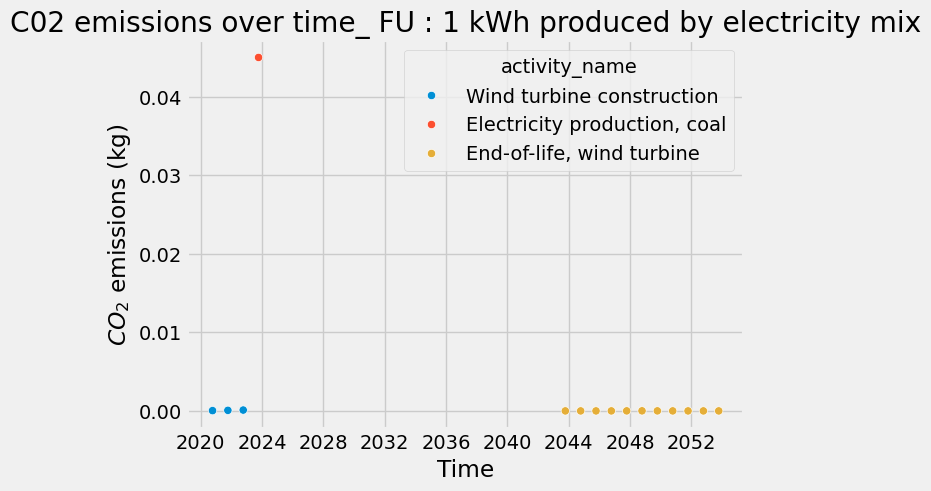

In [57]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

Let's come back to a more realistic share of coal in the mix, but reducing its energy prod over the LT

In [139]:
del bd.databases['wind-example']

In [140]:
bd.databases

Databases dictionary with 0 objects

In [141]:
LT = 25 # 25 years lifetime of a wind turbine
generated_electricity_over_lifetime = 2*1e6*365*24*LT/ 1e6 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.8

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-4,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=5,
                    kind = 'triangular',
                    param = -1
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'normal',
                    param = 0.1
                )
            },
            # aggregate the rest to direct co2 emissions
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 200000,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 70197.56it/s]

Vacuuming database 


In [142]:
lca = bc.LCA({('wind-example', 'electricity-mix'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

4.842626329380516

In [143]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 349


In [144]:
tl = tlca.build_timeline()

In [145]:
import seaborn as sb
import pandas as pd

In [146]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [147]:
df

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit
0,1999-10-11 18:28:27,9.439022e-10,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
1,2000-10-11 00:17:39,1.510244e-08,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
2,2001-10-11 06:06:51,1.283707e-07,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
3,2002-10-11 11:56:03,7.400193e-07,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
4,2002-10-11 11:56:03,1.550359e-08,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
...,...,...,...,...,...,...,...,...
2647,2141-10-11 04:54:51,3.291841e-22,1,8,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
2648,2141-10-11 04:54:51,1.791241e-24,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
2649,2142-10-11 10:44:03,1.957784e-24,1,8,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
2650,2142-10-11 10:44:03,4.965530e-27,1,7,Wind turbine construction,unit,carbon dioxide,kilogram


In [149]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by electricity mix')

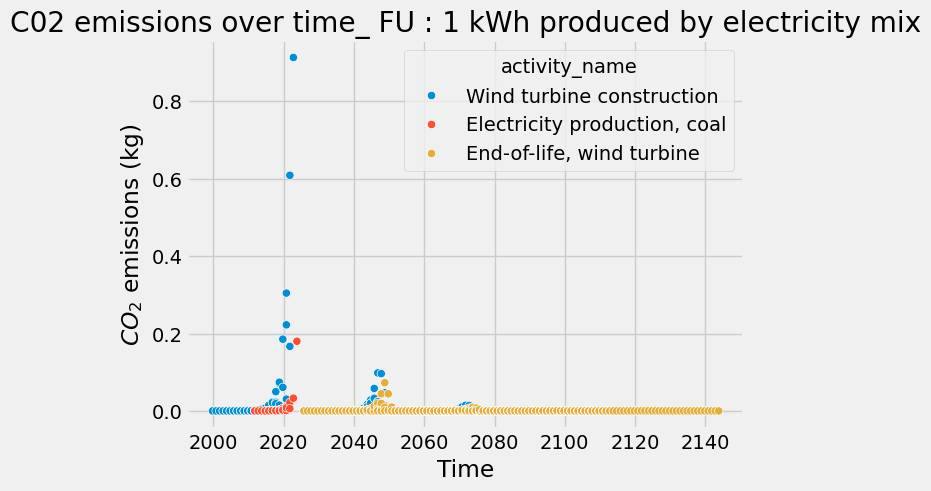

In [150]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

# Put triangular distrubution, just to see what it change

In [139]:
del bd.databases['wind-example']

In [140]:
bd.databases

Databases dictionary with 0 objects

In [151]:
LT = 25 # 25 years lifetime of a wind turbine
generated_electricity_over_lifetime = 2*1e6*365*24*LT/ 1e6 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.8

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-4,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=5,
                    kind = 'triangular',
                    param = -1
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'triangular',
                    param = 25
                )
            },
            # aggregate the rest to direct co2 emissions
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 200000,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 107202.66it/s]

Vacuuming database 


In [152]:
lca = bc.LCA({('wind-example', 'electricity-mix'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

4.842626329380516

In [153]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 349


In [154]:
tl = tlca.build_timeline()

In [155]:
import seaborn as sb
import pandas as pd

In [156]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [157]:
df

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit
0,1999-10-11 18:31:11,9.439022e-10,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
1,2000-10-11 00:20:23,1.510244e-08,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
2,2001-10-11 06:09:35,1.283707e-07,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
3,2002-10-11 11:58:47,1.550359e-08,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
4,2002-10-11 11:58:47,7.400193e-07,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
...,...,...,...,...,...,...,...,...
2269,2137-10-11 05:40:47,1.025666e-07,1,8,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
2270,2137-10-11 05:40:47,2.254974e-08,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
2271,2138-10-11 11:29:59,2.279258e-08,1,8,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
2272,2138-10-11 11:29:59,2.601893e-09,1,7,Wind turbine construction,unit,carbon dioxide,kilogram


In [158]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by electricity mix')

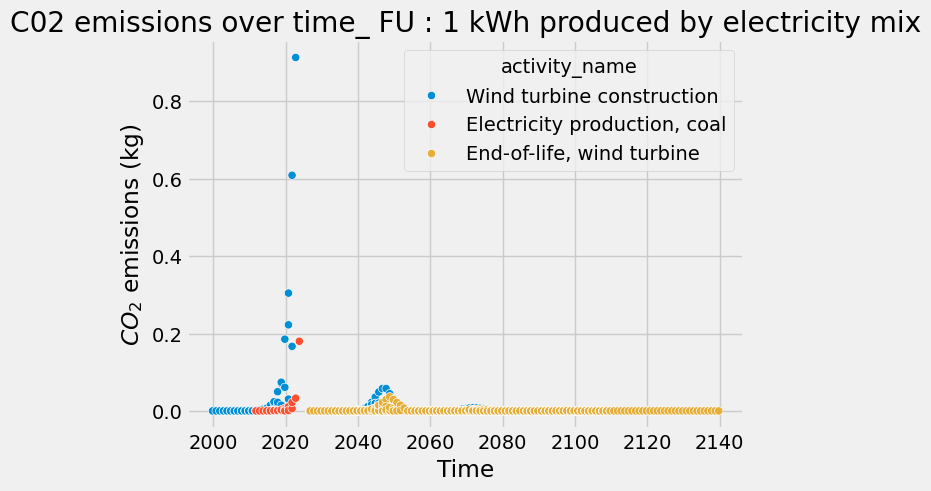

In [159]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

# Adding a TD for the share of wind elec in the elec mix

In [23]:
import bw_temporalis as bwt

<Axes: xlabel='Time (seconds)', ylabel='Amount'>

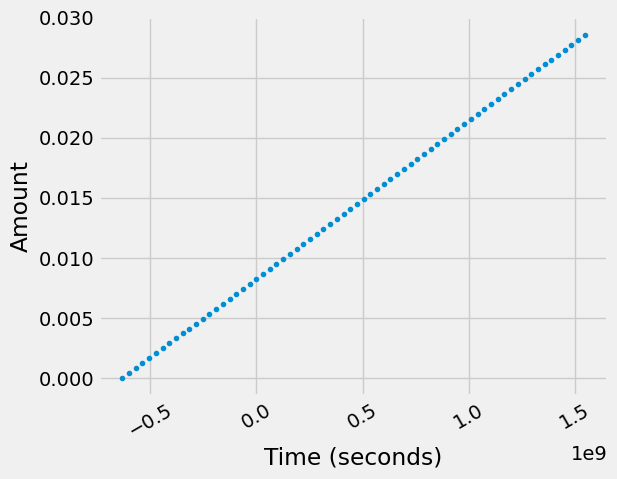

In [174]:
TD_constant_increase_wind_share = bwt.easy_timedelta_distribution(
                    start=-20,
                    end=49,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=70,
                    kind = 'triangular',
                    param = 49
                )
td.graph()

In [139]:
del bd.databases['wind-example']

In [140]:
bd.databases

Databases dictionary with 0 objects

In [175]:
LT = 25 # 25 years lifetime of a wind turbine
generated_electricity_over_lifetime = 2*1e6*365*24*LT/ 1e6 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.8

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
                'temporal_distribution' : TD_constant_increase_wind_share,
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-4,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=5,
                    kind = 'triangular',
                    param = -1
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'triangular',
                    param = 25
                )
            },
            # aggregate the rest to direct co2 emissions
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 200000,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 63191.02it/s]

Vacuuming database 


In [161]:
lca = bc.LCA({('wind-example', 'electricity-mix'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

4.842626329380516

In [162]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 349


In [163]:
tl = tlca.build_timeline()

In [164]:
import seaborn as sb
import pandas as pd

In [165]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [166]:
df

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit
0,1847-10-11 22:04:07,8.158117e-37,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
1,1848-10-11 03:53:19,2.610597e-35,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
2,1849-10-11 09:42:31,4.307486e-34,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
3,1850-10-11 15:31:43,4.855711e-33,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
4,1851-10-11 21:20:55,4.190009e-32,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
...,...,...,...,...,...,...,...,...
37289,2403-10-11 17:59:19,4.737795e-15,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
37290,2404-10-10 23:48:31,1.236131e-15,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
37291,2405-10-11 05:37:43,2.533467e-16,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
37292,2406-10-11 11:26:55,3.634950e-17,1,7,Wind turbine construction,unit,carbon dioxide,kilogram


In [167]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by electricity mix')

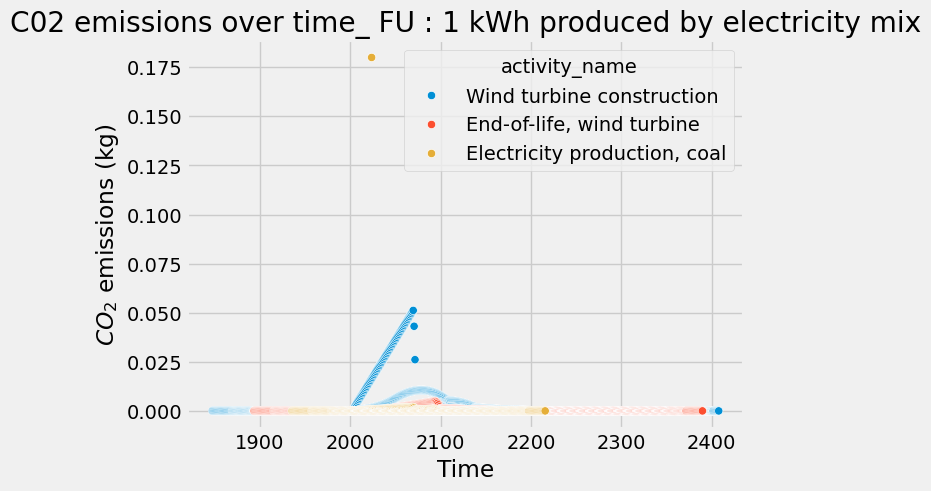

In [168]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

# Adding the corresponding decreasing TD to coal in the energy mix

<Axes: xlabel='Time (seconds)', ylabel='Amount'>

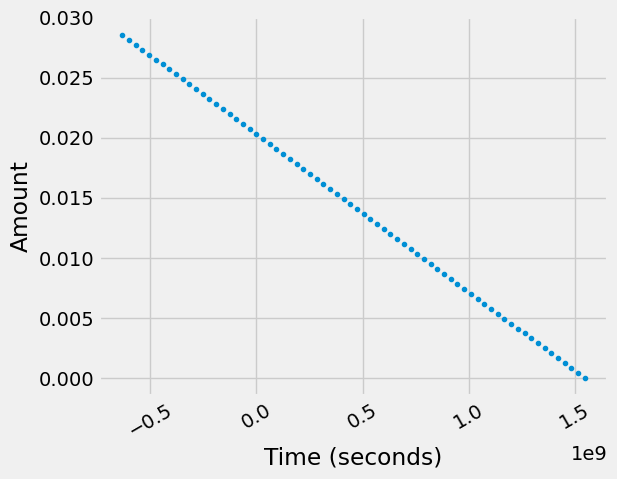

In [170]:
TD_constant_decrease_coal = bwt.easy_timedelta_distribution(
                    start=-20,
                    end=49,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=70,
                    kind = 'triangular',
                    param = -20
                )
TD_constant_decrease_coal.graph()

In [176]:
del bd.databases['wind-example']

In [177]:
bd.databases

Databases dictionary with 0 objects

In [179]:
LT = 25 # 25 years lifetime of a wind turbine
generated_electricity_over_lifetime = 2*1e6*365*24*LT/ 1e6 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.8

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
                'temporal_distribution' : TD_constant_increase_wind_share,
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
                'temporal_distribution': TD_constant_decrease_coal,
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-4,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=5,
                    kind = 'triangular',
                    param = -1
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'triangular',
                    param = 25
                )
            },
            # aggregate the rest to direct co2 emissions
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 200000,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 66182.31it/s]

Vacuuming database 


In [180]:
lca = bc.LCA({('wind-example', 'electricity-mix'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

4.842626329380516

In [181]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 349


In [182]:
tl = tlca.build_timeline()

In [183]:
import seaborn as sb
import pandas as pd

In [184]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [185]:
df

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit
0,1847-10-11 22:13:15,8.158117e-37,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
1,1848-10-11 04:02:27,2.610597e-35,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
2,1849-10-11 09:51:39,4.307486e-34,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
3,1850-10-11 15:40:51,4.855711e-33,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
4,1851-10-11 21:30:03,4.190009e-32,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
...,...,...,...,...,...,...,...,...
38105,2403-10-11 18:08:27,4.737795e-15,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
38106,2404-10-10 23:57:39,1.236131e-15,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
38107,2405-10-11 05:46:51,2.533467e-16,1,7,Wind turbine construction,unit,carbon dioxide,kilogram
38108,2406-10-11 11:36:03,3.634950e-17,1,7,Wind turbine construction,unit,carbon dioxide,kilogram


In [186]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by electricity mix')

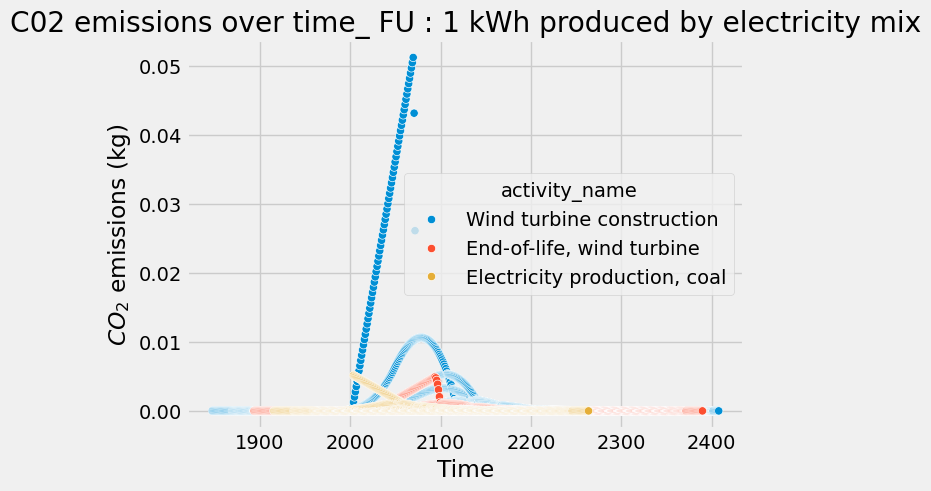

In [187]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service